In [1]:
import sys
sys.path.insert(1, "../")

import importlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression 
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

In [2]:
def reload_modules():
    import ghost_unfairness
    importlib.reload(ghost_unfairness.fair_dataset)
    importlib.reload(ghost_unfairness.utils)
    
reload_modules()

from ghost_unfairness.fair_dataset import FairDataset, default_mappings

from ghost_unfairness.utils import *

In [3]:
def get_datasets(n_samples, n_features, 
                 train_random_state=47, test_random_state=23):
    train_fd = FairDataset(n_samples, n_features, **kwargs,
                      random_state=train_random_state)
    test_fd = FairDataset(n_samples//2, n_features, **kwargs,
                         random_state=test_random_state)
    return train_fd, test_fd

In [4]:
def train_model(model_type, data, params):
    
    x, y = data.get_xy(keep_protected=False)
    
    model = model_type()
    # params[variant] = val
    model.set_params(**params)

    model = model.fit(x, y)

    return model

In [5]:
def get_groupwise_preformance(train_fd, test_fd, model_type,
                              privileged=None,
                              params=None):
    if privileged == True:
        train_fd = train_fd.get_privileged_group()
        
    elif privileged == False:
        train_fd = train_fd.get_unprivileged_group()
        
    if not params:
        params = get_model_params(model_type)
    
    model = train_model(model_type, train_fd, params)
    results = get_classifier_metrics(model, test_fd,
                                     verbose=False)
    
    return model, results

In [6]:
def get_model_params(model_type):
    if model_type == DecisionTreeClassifier:
        params = {'criterion':'entropy',
              'random_state': 47} 
    elif model_type == LogisticRegression:
        params = {'class_weight': 'balanced',
                  'solver': 'liblinear'}
    elif model_type == GaussianNB:
        params = {}
    return params

In [7]:
protected = ["sex"]
privileged_classes = [['Male']]
metadata = default_mappings.copy()
metadata['protected_attribute_maps'] = [{1.0: 'Male', 0.0: 'Female'}]

alpha = 0.5
beta = 1

kwargs = {'protected_attribute_names': protected,
          'privileged_classes': [['Male']],
          'metadata':metadata,
          'favorable_classes': [1],
          'beta': beta,
          'alpha': alpha
         }

# privileged_groups = [{key:1 for key in protected}]
# unprivileged_groups = [{key:0 for key in protected}]

random_state = 47

In [8]:
model_type = GaussianNB

In [32]:
train_fd, test_fd = get_datasets(10000, 2, test_random_state=3)
pmod, pmod_results = get_groupwise_preformance(train_fd, test_fd, model_type,
                                               privileged=True)
umod, umod_results = get_groupwise_preformance(train_fd, test_fd, model_type,
                                               privileged=False)
mod, mod_results = get_groupwise_preformance(train_fd, test_fd, model_type,
                                             privileged=None)

In [33]:
print('pmod_results', *pmod_results, sep='\t')
print('umod_results', *umod_results, sep='\t')
print('mod_results', *mod_results, sep='\t')

pmod_results	-0.12820000000000004	0.7434973989595838	0.9287	0.9998	0.8576
umod_results	-0.03859999999999997	0.927931292008962	0.9447	0.9644	0.925
mod_results	-0.05359999999999998	0.894571203776554	0.9522	0.9916	0.9128


In [11]:
print(np.sqrt(pmod.sigma_))
print(np.sqrt(umod.sigma_))
print(np.sqrt(mod.sigma_))

print()
print(pmod.theta_)
print(umod.theta_)
print(mod.theta_)

[[1.99842399]
 [1.99701377]]
[[5.11499565]
 [4.97410084]]
[[4.17130264]
 [4.0839225 ]]

[[ 3.01710348]
 [12.99475632]]
[[-0.03007637]
 [ 9.95268372]]
[[ 1.49351355]
 [11.47372002]]


In [12]:
import scipy.stats as stats
import math

def plot_normal(mu, sigma, label=None):
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), label=label)
    
def plot_non_linear_boundary(mu1, mu2, sigma1, sigma2, p, d, label=None):
    x = np.linspace(-200, 200, 10000)
    y = np.log(p/(1-p)) - d*np.log(sigma1/sigma1) 
    y -= 1/(2*sigma1**2)*(x-mu1)**2 
    y += 1/(2*sigma2**2)*(x-mu2)**2
    plt.plot(x, y, label=label)
    plt.legend()

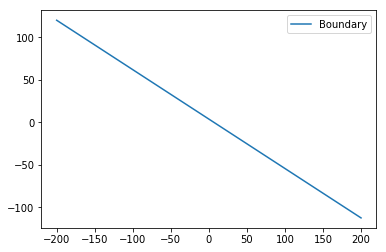

In [13]:
plot_non_linear_boundary(1.5, 11.5, 4.15, 4.15, 0.5, 1, 'Boundary')

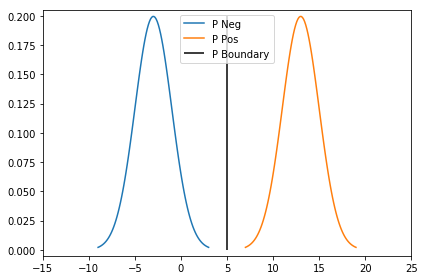

In [14]:
plot_normal(-3, 2, label='P Neg')
plot_normal(13, 2, label='P Pos')
plt.vlines(5, 0, 0.2, label = 'P Boundary')
plt.xlim(-15, 25)
plt.ylim(-0.005, 0.205)
plt.legend()
plt.tight_layout()

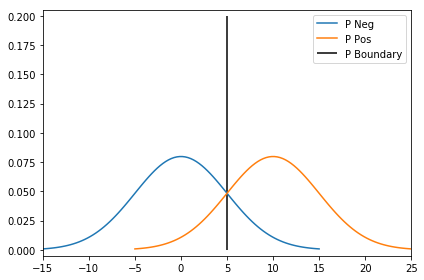

In [15]:
plot_normal(0, 5, label='P Neg')
plot_normal(10, 5, label='P Pos')
plt.vlines(5, 0, 0.2, label = 'P Boundary')
plt.xlim(-15, 25)
plt.ylim(-0.005, 0.205)
plt.legend()
plt.tight_layout()

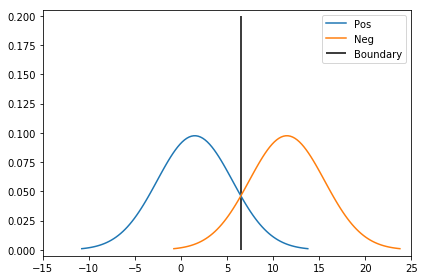

In [16]:
plot_normal(1.5, 4.09, label='Pos')
plot_normal(11.5, 4.09, label='Neg')
plt.vlines(6.5, 0, 0.2, label='Boundary')
plt.xlim(-15, 25)
plt.ylim(-0.005, 0.205)
plt.legend()
plt.tight_layout()

(0, 0.2)

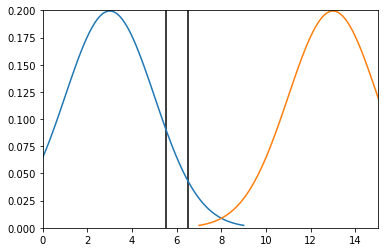

In [17]:
plot_normal(3, 2)
plot_normal(13, 2)
# plt.vlines(6.5, 0, 0.2)
# plot_normal(0, 5)
# plot_normal(10, 5)
plt.vlines(5.5, 0, 0.2)
plt.vlines(6.5, 0, 0.2)
plt.xlim(0, 15)
plt.ylim(0, 0.2)

(0, 0.2)

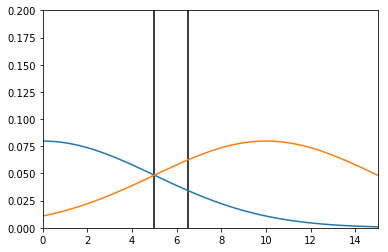

In [18]:
# plot_normal(3, 2)
# plot_normal(10, 2)
# plt.vlines(6.5, 0, 0.2)
plot_normal(0, 5)
plot_normal(10, 5)
plt.vlines(5, 0, 0.2)
plt.vlines(6.5, 0, 0.2)
plt.xlim(0, 15)
plt.ylim(0, 0.2)

In [19]:
model_type = LogisticRegression
train_fd, test_fd = get_datasets(10000, 2, test_random_state=23)
pmod, pmod_results = get_groupwise_preformance(train_fd, test_fd, model_type,
                                               privileged=True)
umod, umod_results = get_groupwise_preformance(train_fd, test_fd, model_type,
                                               privileged=False)
mod, mod_results = get_groupwise_preformance(train_fd, test_fd, model_type,
                                             privileged=None)

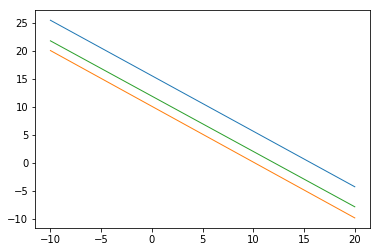

In [20]:
plot_lr_boundary(pmod, plt, -1, -1, -1)
plot_lr_boundary(umod, plt, -1, -1, -1)
plot_lr_boundary(mod, plt, -1, -1, -1)
plt.show()

In [21]:
print("Loss D_p t_p", 1 - pmod_results[3])
print("Loss D_u t_u", 1 - umod_results[4])
print("Loss D t", 1 - mod_results[2])

Loss D_p t_p 0.00019999999999997797
Loss D_u t_u 0.07540000000000002
Loss D t 0.04530000000000001


In [22]:
mods = [pmod, umod, mod]
mods_results = [pmod_results, umod_results, mod_results]
theta_p = None
theta_u = None
theta = None
min_loss_p = 1
min_loss_u = 1
min_loss = 1
for i in range(len(mods)):
    if (1 - mods_results[i][3]) < min_loss_p:
        theta_p = mods[i]
        min_loss_p = 1 - mods_results[i][3]
    if (1 - mods_results[i][4]) < min_loss_u:
        theta_u = mods[i]
        min_loss_u = 1 - mods_results[i][4]
        
    if (1 - mods_results[i][2]) < min_loss:
        theta = mods[i]
        min_loss = 1 - mods_results[i][2]
        
print(1-min_loss_p, 1-min_loss_u, 1-min_loss)
print((beta*min_loss_p + 1*min_loss_u)/(1+beta))
print(min_loss)
assert round(min_loss, 8) - round((beta*min_loss_p + 1*min_loss_u)/(1+beta), 8) >= 0

0.9998 0.9246 0.9547
0.0378
0.04530000000000001


In [23]:
ptrain_results = get_classifier_metrics(pmod, train_fd)

print(ptrain_results)
utrain_results = get_classifier_metrics(umod, train_fd)

print(utrain_results)
train_results = get_classifier_metrics(mod, train_fd)

print(train_results)

[-0.12519999999999998, 0.7496, 0.9315, 0.9998, 0.8632]
[-0.03469999999999995, 0.9352128454070202, 0.94535, 0.9644, 0.9263]
[-0.04629999999999995, 0.909126594700687, 0.95315, 0.9905, 0.9158]


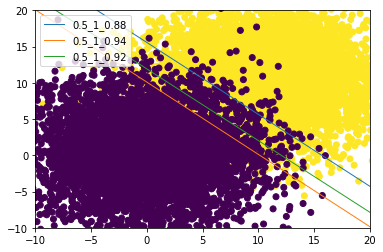

In [24]:
plot_lr_boundary(pmod, plt, alpha, beta, 0.88)
plot_lr_boundary(umod, plt, alpha, beta, 0.94)
plot_lr_boundary(mod, plt, alpha, beta, 0.92)
test_fd_x, test_fd_y = train_fd.get_xy(keep_protected=False)
plt.scatter(test_fd_x['0'], test_fd_x['1'], c=test_fd_y, label=None)
plt.xlim(-10, 20)
plt.ylim(-10, 20)
plt.legend()

In [25]:
dict(zip(test_fd.protected_attribute_names, test_fd.privileged_protected_attributes))

{'sex': array([1.])}

In [26]:
import copy

def get_edge_lr(model, end, interval, criteria):
    cms = {}
    c = 0
    while True:
        temp_mod = copy.deepcopy(model)
        temp_mod.intercept_ = [i + c for i in temp_mod.intercept_]
        cm = get_classifier_metrics(temp_mod, test_fd)

        cms[c] = cm
        if cm[criteria] < end:
            break
        c -= interval
        
    return temp_mod, cms

    
def get_lr_boundary_range(model, criteria):
    cms = {}
    temp_mods = [copy.deepcopy(model)]
    left_mod, cms_left = get_edge_lr(model, 0.6, -0.1, criteria)
    temp_mods.append(left_mod)
    cms = cms_left.copy()
    right_mod, cms_right = get_edge_lr(model, 0.6, 0.1, criteria)
    temp_mods.append(right_mod)
    cms.update(cms_right)

    for lr in temp_mods:
        plot_lr_boundary(lr, plt, 0, 0, 0)
        
    return temp_mods, cms

In [27]:
def plot_cms(cms):
    skeys = sorted(cms.keys())
    accs = [cms[i][3] for i in skeys]
    plt.plot(skeys, accs, label='Pos Acc')

    accs = [cms[i][4] for i in skeys]
    plt.plot(skeys, accs, label='Neg Acc')
    plt.legend()

    accs = [cms[i][2] for i in skeys]
    plt.plot(skeys, accs, label='Ov Acc')
    plt.legend()

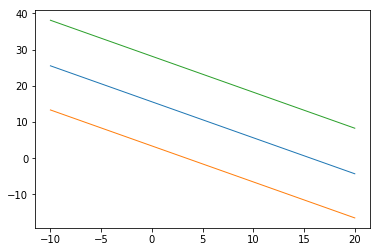

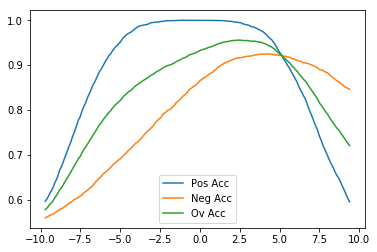

In [28]:
temp_mods, cms = get_lr_boundary_range(pmod, 3)
plt.show()
plot_cms(cms)

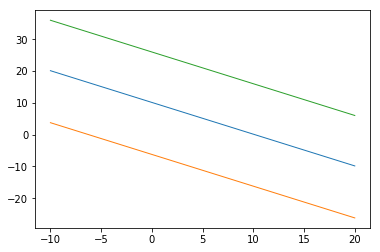

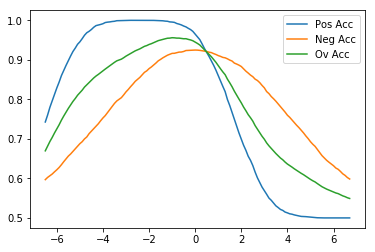

In [29]:
temp_mods, cms = get_lr_boundary_range(umod, 4)
plt.show()
plot_cms(cms)

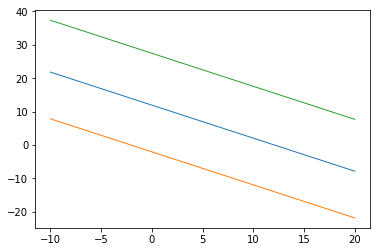

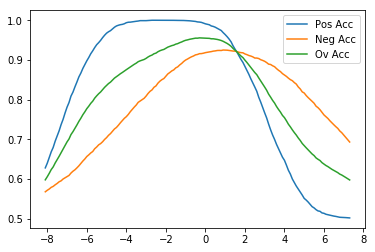

In [30]:
temp_mods, cms = get_lr_boundary_range(mod, 2)
plt.show()
plot_cms(cms)

In [31]:
gammas = [0, 0.2, 0.4, 0.6, 0.8, 1]

cms = {}

for g in gammas:
    temp_mod = copy.deepcopy(pmod)
    intercepts = np.add((1-g)*pmod.intercept_, g*umod.intercept_)
    temp_mod.intercept_ = intercepts
    coefs = np.add((1-g)*pmod.coef_, g*umod.coef_)
    temp_mod.coef_ = coefs
    cm = get_classifier_metrics(temp_mod, test_fd, 
                                unprivileged_groups, privileged_groups)
    cms[g] = cm
    plot_lr_boundary(temp_mod, plt, 0, 0, 0)
    
    
plt.xlim(-10, -5)
plt.ylim(20, 25)
plt.show()
    
skeys = sorted(cms.keys())
accs = [cms[i][3] for i in skeys]
plt.plot(skeys, accs, '*-', label='Pos Acc')

accs = [cms[i][4] for i in skeys]
plt.plot(skeys, accs, '*-', label='Neg Acc')
plt.legend()

accs = [cms[i][2] for i in skeys]
plt.plot(skeys, accs, '*-', label='Ov Acc')
plt.legend()

plt.hlines(0.935, 0, 1)

NameError: name 'unprivileged_groups' is not defined

In [ ]:
print(*[cms[i] for i in cms], sep='\n')

In [ ]:
p = [cms[i][3] for i in cms]
u = [cms[i][4] for i in cms]
u.reverse()
print(p)
print(u)
print([p[0] - p[i] for i in range(1, len(p))])
print([u[0] - u[i] for i in range(1, len(u))])

1. First get the decision boundary (Use NB or LR. maybe both are doable.)
2. Using the boundary get $P(\hat{y} = 1| u/p, \theta_u/\theta_p)$.
3. Show that, $DI(\theta_p)$ < $DI(\theta)$ < $DI(\theta_u)$

In [ ]:
from scipy.stats import norm
def get_positive_prediction_rate(mu1, mu2, sigma1, sigma2, mu_avg):
    rv1 = norm(loc=mu1, scale=sigma1)
    # print(rv1.cdf(mu_avg))
    rv2 = norm(loc=mu2, scale=sigma2)
    # print(rv2.cdf(mu_avg))

    return (1 - 0.5*rv1.cdf(mu_avg) - 0.5 * rv2.cdf(mu_avg))

In [ ]:
print(get_positive_prediction_rate(0, 9, 5, 5, 6.5))
print(get_positive_prediction_rate(3, 10, 2, 2, 6.5))

In [ ]:
0.3941314729298117/0.5

In [ ]:
print(get_positive_prediction_rate(0, 9, 5, 5, 5))
print(get_positive_prediction_rate(3, 10, 2, 2, 5))
get_positive_prediction_rate(0, 9, 5, 5, 5)/get_positive_prediction_rate(3, 10, 2, 2, 5)

In [ ]:
0.5/0.577

In [ ]:
print(get_positive_prediction_rate(0, 10, 5, 5, 5.495))
print(get_positive_prediction_rate(3, 10, 2, 2, 5.495))
get_positive_prediction_rate(0, 10, 5, 5, 5.495)/get_positive_prediction_rate(3, 10, 2, 2, 5.495)

In [ ]:
get_positive_prediction_rate(0, 10, 5, 5, 5.45916)/get_positive_prediction_rate(3, 10, 2, 2, 5.45916)

In [ ]:
print(get_positive_prediction_rate(0, 9, 5, 5, 5.75))
print(get_positive_prediction_rate(3, 10, 2, 2, 5.75))
get_positive_prediction_rate(0, 9, 5, 5, 5.75)/get_positive_prediction_rate(3, 10, 2, 2, 5.75)

In [ ]:
0.4637/0.5333

In [ ]:
i = 5
ratios = []
while i <= 8:
    ratio = get_positive_prediction_rate(0, 10, 5, 5, i)/get_positive_prediction_rate(3, 13, 2, 2, i)
    ratios.append(ratio)
    print(i, ratio, sep='\t\t')
    i+= 0.25
    
plt.plot(np.arange(5, 8.25, 0.25), ratios)

In [ ]:
i = 5
ratios = []
while i <= 6.5:
    ratio = get_positive_prediction_rate(0, 9, 5, 5, i)/get_positive_prediction_rate(3, 10, 2, 2, i)
    ratios.append(ratio)
    print(i, ratio, sep='\t\t')
    i+= 0.25
    
plt.plot(np.arange(5, 6.75,0.25), ratios)

In [ ]:
get_positive_prediction_rate(0, 9, 5, 5, 5.495)/get_positive_prediction_rate(3, 10, 2, 2, 5.495)

In [ ]:
print(get_positive_prediction_rate(0, 10, 5, 5, 8))
print(get_positive_prediction_rate(3, 13, 2, 2, 8))
get_positive_prediction_rate(0, 10, 5, 5, 8)/get_positive_prediction_rate(3, 13, 2, 2, 8)

In [ ]:
print(get_positive_prediction_rate(0, 10, 5, 5, 5))
print(get_positive_prediction_rate(3, 13, 2, 2, 5))
get_positive_prediction_rate(0, 10, 5, 5, 5)/get_positive_prediction_rate(3, 13, 2, 2, 5)

In [ ]:
print(get_positive_prediction_rate(0, 10, 5, 5, 6.5))
print(get_positive_prediction_rate(3, 13, 2, 2, 6.5))
get_positive_prediction_rate(0, 10, 5, 5, 6.5)/get_positive_prediction_rate(3, 13, 2, 2, 6.5)